## 数据

In [1]:
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
prostate = pd.read_csv("../../../datasets/prostate/prostate.data", 
                       sep="\t", index_col=0)
prostate.head()

,lcavol,lweight,age,lbph,svi,lcp,gleason,pgg45,lpsa,train
1,-0.579818,2.769459,50,-1.386294,0,-1.386294,6,0,-0.430783,T
2,-0.994252,3.319626,58,-1.386294,0,-1.386294,6,0,-0.162519,T
3,-0.510826,2.691243,74,-1.386294,0,-1.386294,7,20,-0.162519,T
4,-1.203973,3.282789,58,-1.386294,0,-1.386294,6,0,-0.162519,T
5,0.751416,3.432373,62,-1.386294,0,-1.386294,6,0,0.371564,T


In [3]:
prostate_train = prostate.drop("train", axis=1)[prostate["train"] == "T"]
prostate_test = prostate.drop("train", axis=1)[prostate["train"] == "F"]

In [4]:
scaler = StandardScaler()
scaler.fit(prostate_train)
prostate_train_std = scaler.fit_transform(prostate_train)
prostate_test_std = scaler.transform(prostate_test)

X_train = prostate_train_std[:, :-1]
y_train = prostate_train_std[:, -1]
X_test = prostate_test_std[:, :-1]
y_test = prostate_test_std[:, -1]

## 岭回归

In [10]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

In [11]:
sk_rr = Ridge(normalize=False)
sk_rr.fit(X_train, y_train)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [12]:
y_train_preds = sk_rr.predict(X_train)
train_err = mean_squared_error(y_train, y_train_preds)
print("训练样本误差: {:.3f}".format(train_err)) # 均方差

训练样本误差: 0.306


In [13]:
y_test_preds = sk_rr.predict(X_test)
test_err = mean_squared_error(y_test, y_test_preds)
print("测试样本误差: {:.3f}".format(test_err))

测试样本误差: 0.357


In [14]:
# 系数
sk_rr.coef_

array([ 0.57176338,  0.24157825, -0.11203737,  0.17385446,  0.25161316,
       -0.21232888, -0.00938608,  0.21354104])

### 寻找最优参数

In [15]:
from sklearn.model_selection import GridSearchCV

In [16]:
alphas = np.logspace(-3, 1, 100)
param_grid = {'alpha': alphas}
ridge_cv = GridSearchCV(Ridge(), param_grid=param_grid, cv=10, 
                        scoring='neg_mean_squared_error', iid=False,
                        return_train_score=True)
ridge_cv.fit(X_train, y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=None, normalize=False, random_state=None,
                             solver='auto', tol=0.001),
             iid=False, n_jobs=None,
             param_grid={'alpha': array([1.00000000e-03, 1.09749877e-03, 1.20450354e-03, 1.32194115e-03,
       1.45082878e-03, 1.59228279e-03, 1.74752840e-03, 1.91791026e-03,...
       1.70735265e+00, 1.87381742e+00, 2.05651231e+00, 2.25701972e+00,
       2.47707636e+00, 2.71858824e+00, 2.98364724e+00, 3.27454916e+00,
       3.59381366e+00, 3.94420606e+00, 4.32876128e+00, 4.75081016e+00,
       5.21400829e+00, 5.72236766e+00, 6.28029144e+00, 6.89261210e+00,
       7.56463328e+00, 8.30217568e+00, 9.11162756e+00, 1.00000000e+01])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='neg_mean_squared_error', verbose=0)

In [17]:
best_param = ridge_cv.best_params_
print("最优的L2正则化参数：{}".format(best_param['alpha']))

最优的L2正则化参数：2.0565123083486534


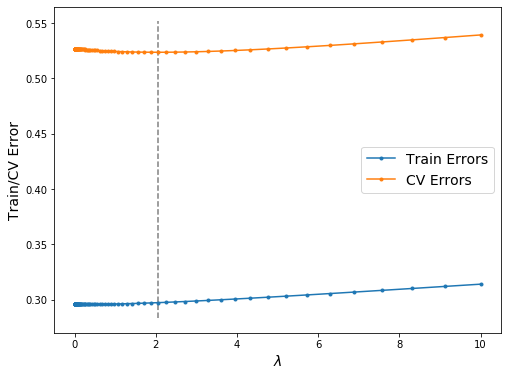

In [18]:
# 画出验证误差曲线
train_errs = -ridge_cv.cv_results_['mean_train_score']
cv_errs = -ridge_cv.cv_results_['mean_test_score']

plt.figure(figsize=(8, 6))
plt.plot(alphas, train_errs, ".-", label="Train Errors")
plt.plot(alphas, cv_errs, ".-", label="CV Errors")
plt.vlines(ridge_cv.best_estimator_.alpha, 
           plt.ylim()[0], plt.ylim()[1],
           color="gray", linestyles="--")
plt.legend(fontsize=14)
plt.xlabel("$\lambda$", fontsize=14)
plt.ylabel("Train/CV Error", fontsize=14)
plt.show()

### 使用最优参数模型

In [19]:
ridge_best = ridge_cv.best_estimator_

In [20]:
y_train_pred = ridge_best.predict(X_train)
train_err = mean_squared_error(y_train, y_train_pred)
print("训练样本误差: {:.3f}".format(train_err)) # 均方差

训练样本误差: 0.307


In [21]:
y_test_pred = ridge_best.predict(X_test)
test_err = mean_squared_error(y_test, y_test_pred)
print("测试样本误差: {:.3f}".format(test_err))

测试样本误差: 0.352


In [22]:
pd.options.display.float_format = '{:.3f}'.format
variables = ["Intercept"] + list(prostate_train.iloc[:, :-1].columns)
pd.DataFrame({"变量": variables, 
              "值": np.r_[prostate_train.iloc[:, -1].mean(), ridge_best.coef_]})

,变量,值
0,Intercept,2.452
1,lcavol,0.552
2,lweight,0.241
3,age,-0.106
4,lbph,0.172
5,svi,0.247
6,lcp,-0.188
7,gleason,-0.003
8,pgg45,0.199
